In [1]:
import csv
import os
import glob
import numpy

def listDirs(dir):
    images = glob.glob(dir + '/*')
    timestamps = [os.path.getctime(path) for path in images]
    indeces = numpy.argsort(timestamps)
    images = [images[idx] for idx in indeces]
    return images

topDir = '/Users/as16542/Downloads/4vnrca7qw1642qlwxjadp87h7/Sub-levels/Identification/Train/RGBDCows2020/Identification/RGB'
dataSet = {"test": [], "train": [], "valid": []}

# Parse the train data
with open('utils/correct.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count > 0 and line_count < 465 and row[6] != 'black':
            label = row[4] if row[4] != '' else row[2]
            if label != '':
                dirs = [dir.replace('/Users/as16542/Downloads/4vnrca7qw1642qlwxjadp87h7/', '') for dir in listDirs(os.path.join(topDir, row[1]))]
                dataSet['train'].append({'label': int(label), 'paths': dirs})
        line_count += 1

# Parse the test data
labels = list(set([item['label'] for item in dataSet["train"]]))
topDir = '/Users/as16542/Downloads/4vnrca7qw1642qlwxjadp87h7/Sub-levels/Identification/Test/'
for label in labels:
    path = os.path.join(topDir, '{:>03}'.format(label))
    dirs = [dir.replace('/Users/as16542/Downloads/4vnrca7qw1642qlwxjadp87h7/', '') for dir in listDirs(path)]
    dataSet["test"].append({'label': int(label), 'paths': dirs})

# Since we omitted black cows we need to hot encode the labels again
labels = list(set([item['label'] for item in dataSet["train"]] + [item['label'] for item in dataSet["test"]]))
hotEncodeMap = {}
for i in range(len(labels)):
    hotEncodeMap[labels[i]] = i

# Now we can use the map the relabel the dataset
for split in dataSet.keys():
    for i in range(len(dataSet[split])):
        dataSet[split][i]['label'] = hotEncodeMap[dataSet[split][i]['label']]

In [4]:
labels = list(set([item['label'] for item in dataSet["train"]] + [item['label'] for item in dataSet["test"]]))
labels

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154]

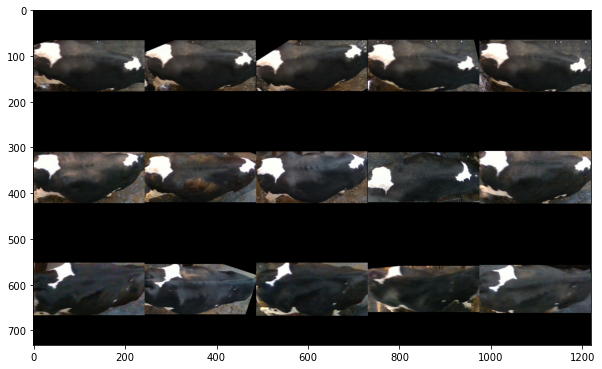

0


In [31]:
from PIL import Image
import matplotlib.pyplot as plt

def loadResizeImage(img_path):
    size = (244, 244)
    # Load the image
    img = Image.open(img_path)

    # Keep the original image size
    old_size = img.size

    # Compute resizing ratio
    ratio = float(size[0]) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])

    # Actually resize it
    img = img.resize(new_size, Image.ANTIALIAS)

    # Paste into centre of black padded image
    new_img = Image.new("RGB", (size[0], size[1]))
    new_img.paste(img, ((size[0] - new_size[0]) // 2, (size[1] - new_size[1]) // 2))

    # Convert to numpy
    new_img = numpy.array(new_img, dtype=numpy.uint8)

    return new_img

# Function to compose images in a grid
compose = lambda images, horizontal: numpy.concatenate(
    [img / 255 if horizontal == 1 else img for img in images],
    axis=horizontal,
)

topDir = "/Users/as16542/Downloads/4vnrca7qw1642qlwxjadp87h7"
for i in range(154):
    # Sample image from the dataset
    trainSet = None
    testSet = None
    negSet = None
    for j in range(len(dataSet["train"])):
        if dataSet["train"][j]["label"] == i:
            trainSet = dataSet["train"][j]["paths"]
            break
    for j in range(len(dataSet["test"])):
        if dataSet["test"][j]["label"] == i:
            testSet = dataSet["test"][j]["paths"]
            break
    for j in range(len(dataSet["test"])):
        if dataSet["test"][j]["label"] == i+1:
            negSet = dataSet["test"][j]["paths"]
            break
    # Take first 5 images
    trainSet, testSet, negSet = [os.path.join(topDir, path) for path in trainSet[:5]], [
        os.path.join(topDir, path) for path in testSet[:5]
    ], [os.path.join(topDir, path) for path in negSet[:5]]

    trainSet, testSet = [loadResizeImage(path) for path in trainSet], [loadResizeImage(path) for path in testSet]
    negSet = [loadResizeImage(path) for path in negSet]
    composite = compose([compose(trainSet, 1), compose(testSet, 1), compose(negSet, 1)], 0)
    plt.imshow(composite)
    plt.show()
    print(i)
    break

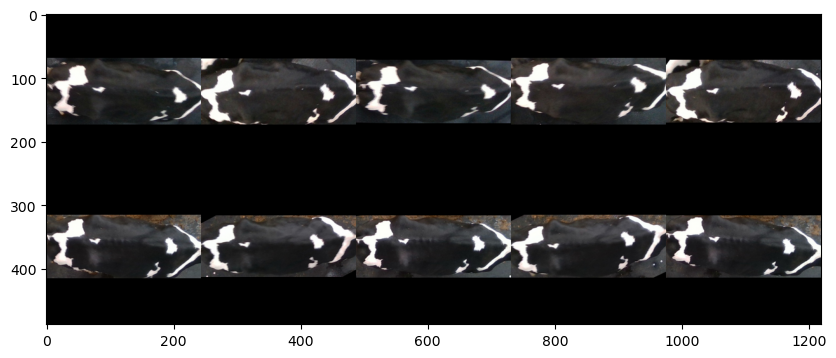

In [29]:
plt.rcParams["figure.figsize"] = (10, 10)
fig, ax = plt.subplots(1, dpi=100)
found = []
for item in dataSet['train']:
    if item['label'] == 153:
        found.append(item)

# Take first 5 images
trainSet, testSet = [os.path.join(topDir, path) for path in found[0]['paths'][:5]], [
    os.path.join(topDir, path) for path in found[1]['paths'][:5]
]

trainSet, testSet = [loadResizeImage(path) for path in trainSet], [loadResizeImage(path) for path in testSet]
composite = compose([compose(trainSet, 1), compose(testSet, 1)], 0)
plt.imshow(composite)
plt.show()


In [63]:
import json
# Save
with open('./utils/opencowsTracklets.json', 'w') as fp:
    json.dump(dataSet, fp)